In [1]:
# suggestions
# use MMSeq2 API for Unitprot mapping
# DisProt training first

In [2]:
import os
import sys
import json
import torch
import keras
import numpy as np
import tensorflow as tf
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


sys.path.append(str(Path().resolve().parent))

from src.arch import DeepEntropy

In [3]:
# loading embedding

nmr_data = torch.load(Path().resolve().parent / "data/embeddings/nmr_filtered.pt")

nmr_embeddings = []
nmr_plddt = []
nmr_gscores = []
for nmr_ele in nmr_data:

    sample_embedding_tf = tf.convert_to_tensor(nmr_ele["embedding"].numpy(), dtype=tf.float32)
    sample_embedding_tf = tf.expand_dims(sample_embedding_tf, axis=0)

    sample_plddt_tf = tf.convert_to_tensor(nmr_ele["plddt"], dtype=tf.float32)
    sample_plddt_tf = tf.expand_dims(sample_plddt_tf, axis=0)

    cleaned_NMR_gscores = [0.0 if v is None else v for v in nmr_ele["gscores"]]
    NMR_gscores_tf = tf.convert_to_tensor(cleaned_NMR_gscores, dtype=tf.float32)
    NMR_gscores_tf = tf.expand_dims(NMR_gscores_tf, axis=0)

    if sample_embedding_tf.shape[2] != 1024:
        print(f"Erorr in embedding dimension! {sample_embedding_tf.shape[1]}")
    elif (sample_embedding_tf.shape[1] != sample_plddt_tf.shape[1]) or (sample_embedding_tf.shape[1] != NMR_gscores_tf.shape[1]):
        print("Unmatching dimension!")
    else:
        nmr_embeddings.append(sample_embedding_tf)
        nmr_plddt.append(sample_plddt_tf)
        nmr_gscores.append(NMR_gscores_tf)


In [4]:
print(len(nmr_embeddings))

994


In [ ]:
disprot_data = torch.load(Path().resolve().parent / "data/embeddings/disprot_merged.pt")

disprot_embeddings = []
disprot_plddt = []
disprot_disorder_values = []
for disprot_ele in disprot_data:
    try:
        sample_embedding_tf = tf.convert_to_tensor(disprot_ele["embedding"].numpy(), dtype=tf.float32)
        sample_embedding_tf = tf.expand_dims(sample_embedding_tf, axis=0)

        sample_plddt_tf = tf.convert_to_tensor(disprot_ele["plddt"], dtype=tf.float32)
        sample_plddt_tf = tf.expand_dims(sample_plddt_tf, axis=0)

        disprot_disorder_tf = tf.convert_to_tensor([disprot_ele["disorder_content"]], dtype=tf.float32)
        disprot_disorder_tf = tf.expand_dims(disprot_disorder_tf, axis=0)


        if sample_embedding_tf.shape[2] != 1024:
            print(f"Erorr in embedding dimension! {sample_embedding_tf.shape[1]}")
        elif (sample_embedding_tf.shape[1] != sample_plddt_tf.shape[1]):
            print(f"Unmatching dimension! {sample_embedding_tf.shape[1]},{sample_plddt_tf.shape[1]}")
        else:
            disprot_embeddings.append(sample_embedding_tf)
            disprot_plddt.append(sample_plddt_tf)
            disprot_disorder_values.append(disprot_disorder_tf)
    except Exception as e:
        print(f"some error occured! Error message: {e}")

In [ ]:
print(len(disprot_embeddings))

In [ ]:
softDis_data = torch.load(Path().resolve().parent / "data/embeddings/softdis_merged.pt")

softDis_embeddings = []
softDis_plddt = []
softDis_disorder_values = []
for softDis_ele in softDis_data:
    try:
        sample_embedding_tf = tf.convert_to_tensor(softDis_ele["embedding"].numpy(), dtype=tf.float32)
        sample_embedding_tf = tf.expand_dims(sample_embedding_tf, axis=0)

        sample_plddt_tf = tf.convert_to_tensor(softDis_ele["plddt"], dtype=tf.float32)
        sample_plddt_tf = tf.expand_dims(sample_plddt_tf, axis=0)

        softDis_disorder_tf = tf.convert_to_tensor(softDis_ele["soft_disorder_frequency"], dtype=tf.float32)
        softDis_disorder_tf = tf.expand_dims(softDis_disorder_tf, axis=0)

        if sample_embedding_tf.shape[2] != 1024:
            print(f"Erorr in embedding dimension! {sample_embedding_tf.shape[1]}")
        elif (sample_embedding_tf.shape[1] != sample_plddt_tf.shape[1]) or (sample_embedding_tf.shape[1] != softDis_disorder_tf.shape[1]):
            print("Unmatching dimension!")
        else:
            softDis_embeddings.append(sample_embedding_tf)
            softDis_plddt.append(sample_plddt_tf)
            softDis_disorder_values.append(softDis_disorder_tf)
    except Exception as e:
        print(f"some error occured! Error message: {e}")

In [ ]:
print(len(softDis_embeddings))

In [ ]:
# temporarily reducing sample size
nmr_embeddings = nmr_embeddings[:10]
nmr_plddt = nmr_plddt[:10]
nmr_gscores = nmr_gscores[:10]

disprot_embeddings = disprot_embeddings[:10]
disprot_plddt = disprot_plddt[:10]
disprot_disorder_values = disprot_disorder_values[:10]

softDis_embeddings = softDis_embeddings[:10]
softDis_plddt = softDis_plddt[:10]
softDis_disorder_values = softDis_disorder_values[:10]

In [10]:
entropy = DeepEntropy()
print(entropy.encoder.summary())
print(entropy.nmr_head_model.summary())
print(entropy.DisProt_head_model.summary())
print(entropy.softdis_head_model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embeddings          │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ plddt (InputLayer)  │ (None, None, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 64)  │    196,672 │ embeddings[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, None, 64)  │        256 │ plddt[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, None, 32)  │      6,176 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, None, 32)  │      6,176 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, None, 16)  │      1,552 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, None, 16)  │      1,552 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, None, 8)   │        392 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, None, 8)   │        392 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 16)  │          0 │ conv1d_3[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_7[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 213,168 (832.69 KB)

 Trainable params: 213,168 (832.69 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ combined_features (InputLayer)  │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 64)       │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ g_scores (Dense)                │ (None, None, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ combined_features (InputLayer)  │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 64)       │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disorder_content (Dense)        │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ combined_features (InputLayer)  │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, 64)       │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ soft_disorder_frequency (Dense) │ (None, None, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
EPOCHS = 100
LEARNING_RATE = 0.001

In [12]:

# Compile the model
entropy.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    NMR_head_loss_fn = keras.losses.MeanSquaredError(),
    DisProt_head_loss_fn = keras.losses.MeanSquaredError(),
    SoftDis_head_loss_fn = keras.losses.MeanSquaredError()
)

In [ ]:
nmr_loss_per_epoc = []
disprot_loss_per_epoc = []
softdis_loss_per_epoc = []

for epoch in range(EPOCHS):
    print(f"Epoch: {epoch+1}")
    nmr_loss_per_sample = []
    disprot_loss_per_sample = []
    softdis_loss_per_sample = []

    print(f"NMR head training epoch: {epoch+1}")
    for idx in range(len(nmr_embeddings)):
        entropy.target_flag_ = "g_scores"
        data = (nmr_embeddings[idx], nmr_plddt[idx], nmr_gscores[idx])
        history = entropy.fit(data)
        nmr_loss_per_sample.append(history.history['loss'][0])

    nmr_loss_per_epoc.append(sum(nmr_loss_per_sample) / len(nmr_loss_per_sample))

    print(f"DisProt head training epoch: {epoch+1}")
    for idx in range(len(disprot_embeddings)):
        entropy.target_flag_ = "disprot_disorder"
        data = (disprot_embeddings[idx], disprot_plddt[idx], disprot_disorder_values[idx])
        history = entropy.fit(data)
        disprot_loss_per_sample.append(history.history['loss'][0])

    disprot_loss_per_epoc.append(sum(disprot_loss_per_sample) / len(disprot_loss_per_sample))

    print(f"SoftDis head training epoch: {epoch+1}")
    for idx in range(len(softDis_embeddings)):
        entropy.target_flag_ = "softdis_disorder"
        data = (softDis_embeddings[idx], softDis_plddt[idx], softDis_disorder_values[idx])
        history = entropy.fit(data)
        softdis_loss_per_sample.append(history.history['loss'][0])

    softdis_loss_per_epoc.append(sum(softdis_loss_per_sample) / len(softdis_loss_per_sample))


Epoch: 1
NMR head training epoch: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 8.8395
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step - loss: 0.8263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0390
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0644
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0080
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0234
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0013
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0173
1/1 ━━━━━━━

In [ ]:
print(nmr_loss_per_epoc)
print(disprot_loss_per_epoc)
print(softdis_loss_per_epoc)

[0.17725923174177297, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.08049802119930974, 0.0804980211

In [15]:
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_nmr_100")
dir_path = f"{str(Path().resolve().parent)}/data/models/{timestamp}"
os.makedirs(dir_path, exist_ok=True)

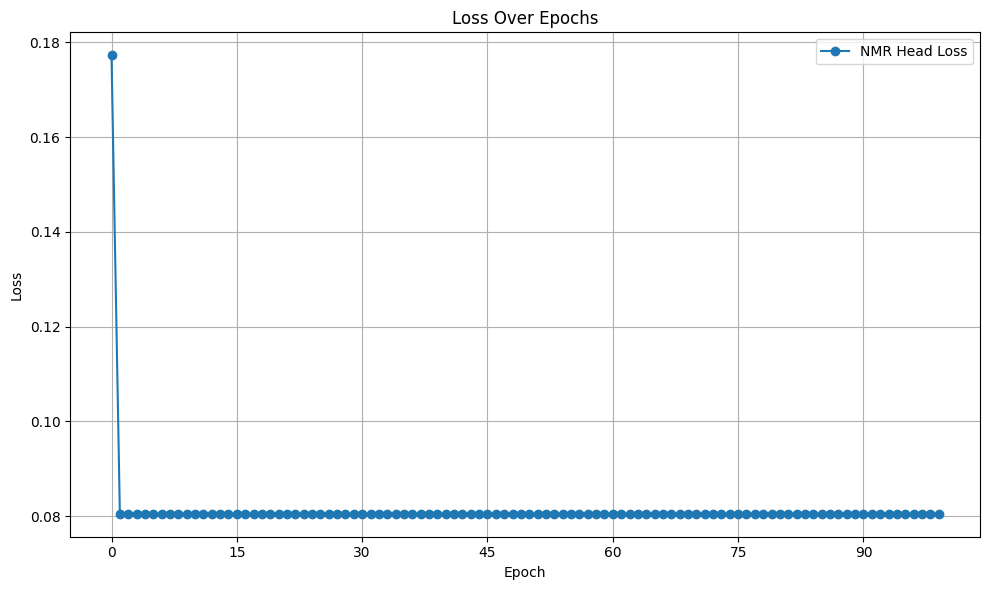

In [ ]:
epochs = [i for i in range(len(nmr_loss_per_epoc))]

plt.figure(figsize=(10, 6))
plt.plot(epochs, nmr_loss_per_epoc, label='NMR Head Loss', marker='o')
plt.plot(epochs, disprot_loss_per_epoc, label='DisProt Head Loss', marker='s')
plt.plot(epochs, softdis_loss_per_epoc, label='SoftDis Head Loss', marker='^')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
full_path = os.path.join(dir_path, "loss_curve_per_epochs.png")
plt.savefig(full_path)
plt.show()

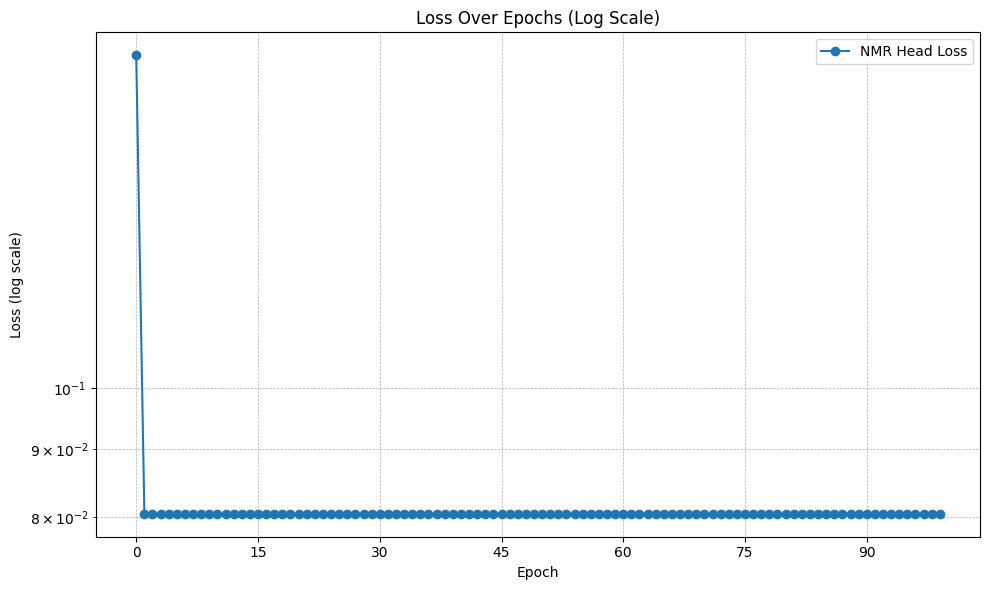

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(epochs, nmr_loss_per_epoc, label='NMR Head Loss', marker='o')
plt.plot(epochs, disprot_loss_per_epoc, label='DisProt Head Loss', marker='s')
plt.plot(epochs, softdis_loss_per_epoc, label='SoftDis Head Loss', marker='^')

plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Loss Over Epochs (Log Scale)")
plt.yscale('log')  # Set y-axis to log scale
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
full_path = os.path.join(dir_path, "log_loss_curve_per_epochs.png")
plt.savefig(full_path)
plt.show()


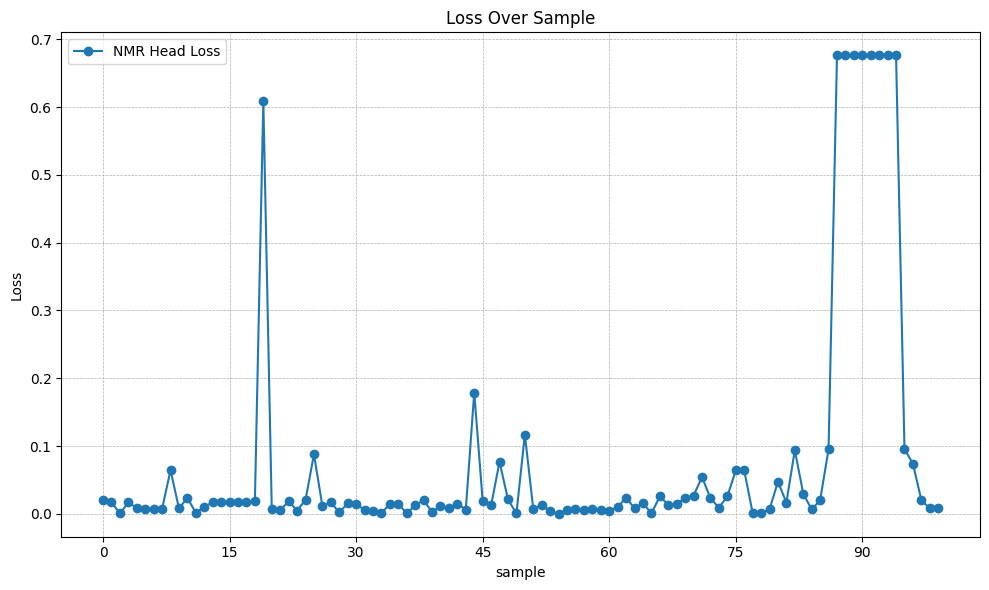

In [ ]:
epochs = list(range(len(nmr_loss_per_sample)))

plt.figure(figsize=(10, 6))

plt.plot(epochs, nmr_loss_per_sample, label='NMR Head Loss', marker='o')
plt.plot(epochs, disprot_loss_per_sample, label='DisProt Head Loss', marker='s')
plt.plot(epochs, softdis_loss_per_sample, label='SoftDis Head Loss', marker='^')

plt.xlabel("sample")
plt.ylabel("Loss")
plt.title("Loss Over Sample")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
full_path = os.path.join(dir_path, "loss_curve_per_sample.png")
plt.savefig(full_path)
plt.show()
